# Setup

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Get To Know Data

In [39]:
df = pd.read_csv('../data/covid_dataset.csv')

In [40]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Preprocessing

## Missing Values

In [41]:
df.replace({97: pd.NA, 98: pd.NA, 99: pd.NA}, inplace=True)

In [42]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    # Check if the column contains missing values
    if df[col].isna().any():
        # Replace missing values with the mode (most frequent value)
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)  # Reassigning directly to avoid chained assignment warning

# Confirm the changes
print(df[categorical_columns].head())

C:\Users\ilham\AppData\Local\Temp\ipykernel_13264\3004967662.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode_value)  # Reassigning directly to avoid chained assignment warning


    DATE_DIED  INTUBED  PNEUMONIA  AGE  PREGNANT  DIABETES  COPD  ASTHMA  \
0  03/05/2020        2          1   65         2         2     2       2   
1  03/06/2020        2          1   72         2         2     2       2   
2  09/06/2020        1          2   55         2         1     2       2   
3  12/06/2020        2          2   53         2         2     2       2   
4  21/06/2020        2          2   68         2         1     2       2   

   INMSUPR  HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  \
0        2             1              2               2        2   
1        2             1              2               2        1   
2        2             2              2               2        2   
3        2             2              2               2        2   
4        2             1              2               2        2   

   RENAL_CHRONIC  TOBACCO  ICU  
0              2        2    2  
1              1        2    2  
2              2        2    2  
3 

In [43]:
relevant_features = [
    'SEX', 'AGE', 'PNEUMONIA', 'DIABETES', 'ASTHMA', 
    'INTUBED', 'ICU', 'HIPERTENSION', 'CARDIOVASCULAR', 
    'RENAL_CHRONIC', 'OBESITY', 'TOBACCO', 'CLASIFFICATION_FINAL'
]

df = df[relevant_features]

missing_threshold = 0.5  # For example, drop columns with >50% missing values

missing_percentages = df.isna().mean()

df = df.loc[:, missing_percentages <= missing_threshold]

print("Remaining columns after filtering:", df.columns)

Remaining columns after filtering: Index(['SEX', 'AGE', 'PNEUMONIA', 'DIABETES', 'ASTHMA', 'INTUBED', 'ICU',
       'HIPERTENSION', 'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OBESITY', 'TOBACCO',
       'CLASIFFICATION_FINAL'],
      dtype='object')


## Encoding

In [44]:
# Define age bins and labels
age_bins = [0, 20, 40, 60, 80, 120] 
age_labels = ['<20', '20-40', '40-60', '60-80', '80+'] 

# Add the AGE_GROUP column with categorized labels
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Map the age groups to numerical values
age_group_mapping = {'<20': 0, '20-40': 1, '40-60': 2, '60-80': 3, '80+': 4}
df['AGE_GROUP'] = df['AGE_GROUP'].map(age_group_mapping)

# Print the results to verify
print(df[['AGE', 'AGE_GROUP']].head())

   AGE AGE_GROUP
0   65         3
1   72         3
2   55         2
3   53         2
4   68         3


In [45]:
df['CLASIFFICATION_FINAL'] = df['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

print(df['CLASIFFICATION_FINAL'].value_counts())

CLASIFFICATION_FINAL
0    656596
1    391979
Name: count, dtype: int64


In [46]:
# check if there is nan values in the AGE_GROUP column
print(df['AGE_GROUP'].isnull().sum())
df['AGE_GROUP'].fillna(df['AGE_GROUP'].mode()[0], inplace=True)

6


C:\Users\ilham\AppData\Local\Temp\ipykernel_13264\1712841479.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AGE_GROUP'].fillna(df['AGE_GROUP'].mode()[0], inplace=True)


## Visualization

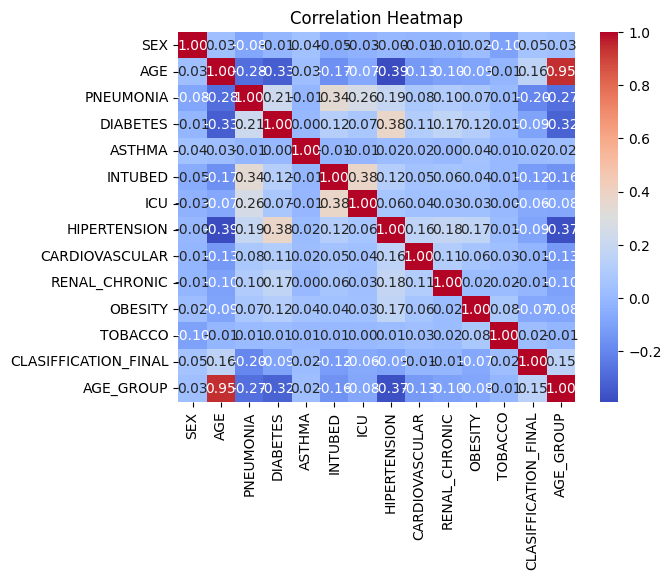

In [47]:
correlation_matrix = df.corr()

plt.figure()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

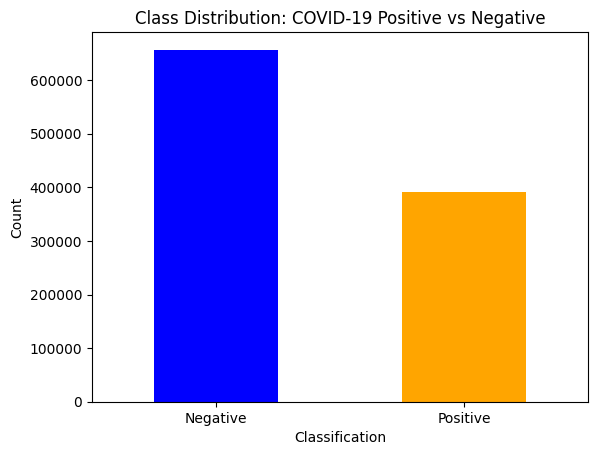

In [48]:
class_counts = df['CLASIFFICATION_FINAL'].value_counts()

plt.figure()
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution: COVID-19 Positive vs Negative')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')
plt.xlabel('Classification')
plt.show()

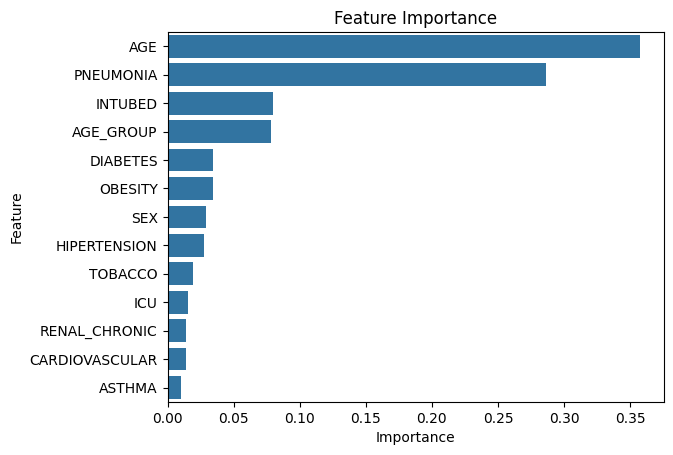

In [49]:
X = df.drop(columns=['CLASIFFICATION_FINAL'])
y = df['CLASIFFICATION_FINAL']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure()
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

In [50]:
high_correlation_threshold = 0.7
highly_correlated_pairs = correlation_matrix.unstack().sort_values(kind="quicksort").drop_duplicates()

redundant_features = highly_correlated_pairs[(highly_correlated_pairs > high_correlation_threshold) & 
                                             (highly_correlated_pairs < 1)]

print("Highly Correlated Feature Pairs:")
print(redundant_features)

Highly Correlated Feature Pairs:
AGE_GROUP  AGE    0.945266
dtype: float64


In [51]:
def chi_square_test(data, categorical_cols, target_col):
    results = {}
    for col in categorical_cols:
        if col != target_col:
            contingency_table = pd.crosstab(data[col], data[target_col])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            results[col] = p  # p-value indicates the strength of dependency
    return results

categorical_cols = ['SEX', 'TOBACCO', 'ICU', 'INTUBED', 'PNEUMONIA', 'HIPERTENSION', 
                    'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OBESITY', 'AGE_GROUP']

chi_square_results = chi_square_test(df, categorical_cols, 'CLASIFFICATION_FINAL')

for feature, p_value in chi_square_results.items():
    print(f"Feature: {feature}, P-value: {p_value}")

Feature: SEX, P-value: 0.0
Feature: TOBACCO, P-value: 1.7648462285815e-95
Feature: ICU, P-value: 0.0
Feature: INTUBED, P-value: 0.0
Feature: PNEUMONIA, P-value: 0.0
Feature: HIPERTENSION, P-value: 0.0
Feature: CARDIOVASCULAR, P-value: 6.375366855715209e-27
Feature: RENAL_CHRONIC, P-value: 4.4611684386460365e-41
Feature: OBESITY, P-value: 0.0
Feature: AGE_GROUP, P-value: 0.0


In [53]:
df.to_csv("../data/covid_preprocessed.csv", index=False)